### Pre-processing Data Steps

In [33]:
import pandas as pd
from datetime import datetime
import re

# Directory containing the F1 dataset
base_dir = '/Users/sanohijatav/Downloads/Business_Project/F1_Dataset/'

# Load race results and calendar data for each year (2019-2024)
years = range(2019, 2025)
race_results_data = []
calendar_data = []

for year in years:
    race_results_file = f'{base_dir}/{year}/formula1_{year}season_raceResults.csv'
    calendar_file = f'{base_dir}/{year}/formula1_{year}season_calendar.csv'
    
    race_results = pd.read_csv(race_results_file)
    calendar = pd.read_csv(calendar_file)
    
    # Add year column to both datasets
    race_results['Year'] = year
    calendar['Year'] = year
    
    race_results_data.append(race_results)
    calendar_data.append(calendar)

# Concatenate data from all years
race_results_data = pd.concat(race_results_data, ignore_index=True)
calendar_data = pd.concat(calendar_data, ignore_index=True)

print(race_results_data.columns)

# Convert Race Date to datetime in calendar data
calendar_data['Race Date'] = pd.to_datetime(calendar_data['Race Date'], format='%d/%m/%Y', errors='coerce')

def time_to_seconds(time_str, prev_total=0, avg_lap_time=80):

    if pd.isna(time_str) or time_str in ["DNF", "DNS"]:
        return None
    time_str = str(time_str).strip()

    # Handling lap differences
    if time_str.endswith('lap') or time_str.endswith('laps'):
        laps = int(time_str.split()[0])
        return prev_total + (laps * avg_lap_time)

    # Handling '+X.XXXs' format
    if time_str.startswith('+') and time_str.endswith('s'):
        return prev_total + float(time_str[1:-1])

    # Full time format (for the race winner)
    match = re.match(r'(\d+):(\d+):(\d+)', time_str)
    if match:
        h, m, s = match.groups()
        return int(h) * 3600 + int(m) * 60 + float(s)

    return None  # For other unexpected formats

def process_race_times(group):
    if isinstance(group, pd.Series):
        winner_time = group.iloc[0]
    else:
        winner_time = group['Time/Retired'].iloc[0]
    
    winner_seconds = time_to_seconds(winner_time)
    
    if winner_seconds is None:
        return pd.Series([None] * len(group))
    
    if isinstance(group, pd.Series):
        return group.apply(lambda x: time_to_seconds(x, prev_total=winner_seconds))
    else:
        return group['Time/Retired'].apply(lambda x: time_to_seconds(x, prev_total=winner_seconds))

# Apply the processing function without groupby
race_results_data['Time_Seconds'] = race_results_data.groupby(['Year', 'Country'])['Time/Retired'].transform(process_race_times)

# Remove rows where Time_Seconds is None (this includes DNF, DNS, and other invalid entries)
race_results_data = race_results_data.dropna(subset=['Time_Seconds'])

# Convert Position to numeric and remove any rows where it's not a valid number
race_results_data['Position'] = pd.to_numeric(race_results_data['Position'], errors='coerce')
race_results_data = race_results_data.dropna(subset=['Position'])

# Convert Position to integer
race_results_data['Position'] = race_results_data['Position'].astype(int)

# Calculate and print total entries after filtering
print("\nAfter processing and filtering:")
for year in years:
    year_data = race_results_data[race_results_data['Year'] == year]
    total = len(year_data)
    print(f"{year}: Total entries: {total}")

# Print a sample of the processed data to verify
print("\nSample of processed data:")
print(race_results_data[['Position', 'Time/Retired', 'Time_Seconds']].head(20))

# Merge race results data with calendar data
merged_data = pd.merge(race_results_data, calendar_data[['Country', 'Race Date', 'Year', 'GP Name']], 
                       on=['Country', 'Year'], how='left')

# Sort the data by Race Date and then by Position
merged_data = merged_data.sort_values(['Race Date', 'Position'])

# Handle the cancelled race in Italy for 2023
cancelled_race = merged_data[(merged_data['Country'] == 'Italy') & (merged_data['Year'] == 2023) & (merged_data['Race Date'].isna())]
if not cancelled_race.empty:
    print("\nCancelled race detected:")
    print(cancelled_race[['Country', 'Year', 'GP Name']])
    # Add note to 'GP Name'
    merged_data.loc[(merged_data['Country'] == 'Italy') & (merged_data['Year'] == 2023) & (merged_data['Race Date'].isna()), 'GP Name'] += ' (Cancelled)'

# Filter to include data up to 2024
merged_data = merged_data[merged_data['Race Date'].dt.year <= 2024]

print("\nMerged Data:")
print(merged_data['Year'].value_counts().sort_index())

# Check the date range in the final dataset
print("\nDate range in the final dataset:")
print(merged_data['Race Date'].min(), "-", merged_data['Race Date'].max())

# Print the last few races in the dataset
print("\nLast few races in the dataset:")
print(merged_data.tail(15))

# Save the merged data to a CSV file
merged_data.to_csv(f'{base_dir}/merged_race_data.csv', index=False)
print("\nMerged data saved to 'merged_race_data.csv'")

Index(['Country', 'Position', 'No', 'Driver', 'Team', 'Starting Grid', 'Laps',
       'Time/Retired', 'Points', 'Fastest Lap', 'Unnamed: 10', 'Unnamed: 11',
       'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Year',
       'Set Fastest Lap'],
      dtype='object')

After processing and filtering:
2019: Total entries: 360
2020: Total entries: 283
2021: Total entries: 381
2022: Total entries: 366
2023: Total entries: 374
2024: Total entries: 252

Sample of processed data:
    Position Time/Retired  Time_Seconds
0          1      1:25:27      5127.000
1          2     +20.886s      5147.886
2          3     +22.520s      5149.520
3          4     +57.109s      5184.109
4          5     +58.230s      5185.230
5          6     +87.156s      5214.156
6          7       +1 lap      5207.000
7          8       +1 lap      5207.000
8          9       +1 lap      5207.000
9         10       +1 lap      5207.000
10        11       +1 lap      5207.000
11        12       +1 lap    

### Validating Report the pre-processed data

In [34]:
def validate_race_data(data):
    print("\nValidation Report:")
    # Check for duplicate positions in the same race
    duplicates = data[data.duplicated(subset=['Country', 'Year', 'Position'], keep=False)]
    if duplicates.empty:
        print("✓ No duplicate positions found in any race.")
    else:
        print(f"❌ Found {len(duplicates)} instances of duplicate positions:")
        print(duplicates[['Position', 'Driver', 'Country', 'Year', 'GP Name']])
    
    # Check for missing values in key columns
    key_columns = ['Position', 'Driver', 'Country', 'Year', 'Race Date', 'GP Name']
    missing_values = data[data[key_columns].isnull().any(axis=1)]
    if missing_values.empty:
        print("✓ No missing values in key columns.")
    else:
        print(f"❌ Found {len(missing_values)} rows with missing values in key columns:")
        print(missing_values[key_columns])
    
    # Check for any Position values outside expected range (1 to 20)
    out_of_range = data[(data['Position'] < 1) | (data['Position'] > 20)]
    if out_of_range.empty:
        print("✓ All Position values are within expected range (1-20).")
    else:
        print(f"❌ Found {len(out_of_range)} Position values outside expected range (1-20):")
        print(out_of_range[['Position', 'Driver', 'Country', 'Year', 'GP Name']])
    
    # Check for date consistency
    date_issues = data[data.groupby(['Year', 'Country'])['Race Date'].transform('nunique') > 1]
    if date_issues.empty:
        print("✓ Race dates are consistent within each race.")
    else:
        print("❌ Found inconsistent race dates:")
        print(date_issues[['Country', 'Year', 'GP Name', 'Race Date']])
    
    # Summary statistics
    print("\nSummary Statistics:")
    print(f"Total races: {data['GP Name'].nunique()}")
    print(f"Total drivers: {data['Driver'].nunique()}")
    print(f"Year range: {data['Year'].min()} - {data['Year'].max()}")
    print(f"Average number of classified drivers per race: {data.groupby(['Country', 'Year'])['Driver'].count().median():.2f}")

# Call the validation function
validate_race_data(merged_data)


Validation Report:
✓ No duplicate positions found in any race.
✓ No missing values in key columns.
✓ All Position values are within expected range (1-20).
✓ Race dates are consistent within each race.

Summary Statistics:
Total races: 87
Total drivers: 35
Year range: 2019 - 2024
Average number of classified drivers per race: 17.00


### Below codes are utilised from the Exploratory Data Analysis so they can used for the prediction models

In [35]:
#Normalizing Team Names Mapping

def get_team_mapping():
    return {
        'Red Bull': ['Red Bull', 'Red Bull Racing', 'Red Bull Racing Honda', 'Red Bull Racing RBPT', 'Red Bull Racing Honda RBPT'],
        'Mercedes': ['Mercedes', 'Mercedes AMG', 'Mercedes-AMG Petronas'],
        'Ferrari': ['Ferrari', 'Scuderia Ferrari'],
        'McLaren': ['McLaren', 'McLaren F1 Team', 'McLaren Renault', 'McLaren Mercedes'],
        'Aston Martin': ['Aston Martin', 'Racing Point', 'Force India', 'Racing Point BWT Mercedes', 'Aston Martin Mercedes', 'Aston Martin Aramco Mercedes'],
        'Alpine': ['Alpine', 'Renault', 'Alpine Renault'],
        'AlphaTauri': ['AlphaTauri', 'Toro Rosso', 'Scuderia Toro Rosso Honda', 'AlphaTauri Honda', 'AlphaTauri RBPT', 'AlphaTauri Honda RBPT', 'RB Honda RBPT'],
        'Kick Sauber': ['Alfa Romeo', 'Sauber', 'Alfa Romeo Racing Ferrari', 'Alfa Romeo Ferrari', 'Kick Sauber Ferrari'],
        'Williams': ['Williams', 'Williams Mercedes'],
        'Haas': ['Haas', 'Haas F1 Team', 'Haas Ferrari'],
    }

def normalize_team_name(team, team_mapping):
    team = team.strip()  # To Remove leading/trailing whitespace
    for normalized_name, variations in team_mapping.items():
        if any(variation.lower() == team.lower() for variation in variations):
            return normalized_name
    return team  

In [36]:
import pandas as pd
import os

data = {}
base_path = 'F1_Dataset'

for year in range(2019, 2025):
    year_path = os.path.join(base_path, str(year))
    for file in os.listdir(year_path):
        if file.endswith('.csv'):
            key = f"{year}_{file[:-4]}"
            data[key] = pd.read_csv(os.path.join(year_path, file))


#Function to load race results from 2019-2024 which will be used further in the EDA Analysis

def get_race_results():
    all_results = pd.DataFrame()
    for year in range(2019, 2025):
        key = f"{year}_formula1_{year}season_raceResults"
        if key in data:
            year_results = data[key].copy()
            year_results['Year'] = year
            all_results = pd.concat([all_results, year_results], ignore_index=True)
    return all_results

#Function to load qualifying race results from 2019-2024 which will be used further in prediction models

def get_qualifying_results():
    all_results = pd.DataFrame()
    for year in range(2019, 2025):
        # Construct the file path for qualifying results
        file_path = f"/Users/sanohijatav/Downloads/Business_Project/F1_Dataset/{year}/formula1_{year}season_qualifyingResults.csv"
        try:
            # Read the CSV file
            year_results = pd.read_csv(file_path)
            # Add a year column
            year_results['Year'] = year
            # Concatenate the results
            all_results = pd.concat([all_results, year_results], ignore_index=True)
        except FileNotFoundError:
            print(f"File not found: {file_path}")
        except pd.errors.EmptyDataError:
            print(f"Empty data file: {file_path}")
        except Exception as e:
            print(f"An error occurred while processing {file_path}: {e}")
    return all_results

#Function to load race calendars from 2019-2024 which will be used further in prediction models

def get_races_per_year():
    races_per_year = {}
    for year in range(2019, 2025):
        key = f"{year}_formula1_{year}season_calendar"
        if key in data:
            races_per_year[year] = len(data[key])
    
    return pd.Series(races_per_year)

def get_race_results():
    all_results = pd.DataFrame()
    for year in range(2019, 2025):
        key = f"{year}_formula1_{year}season_raceResults"
        if key in data:
            year_results = data[key].copy()
            year_results['Year'] = year
            all_results = pd.concat([all_results, year_results], ignore_index=True)
    return all_results

In [37]:
pip install --upgrade scikit-learn xgboost


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [38]:
pip install tabulate


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### PREDICTION MODEL: Histogram Gradient Booster Classifier

Histogram Gradient Boosting Classifier Model
Cross-validation scores: [0.83168317 0.86104218 0.86848635 0.85856079 0.85359801]
Mean CV accuracy: 0.8547 (+/- 0.0249)
Test set accuracy: 0.8688

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.95      0.92       337
           1       0.64      0.48      0.55        67

    accuracy                           0.87       404
   macro avg       0.77      0.71      0.74       404
weighted avg       0.86      0.87      0.86       404



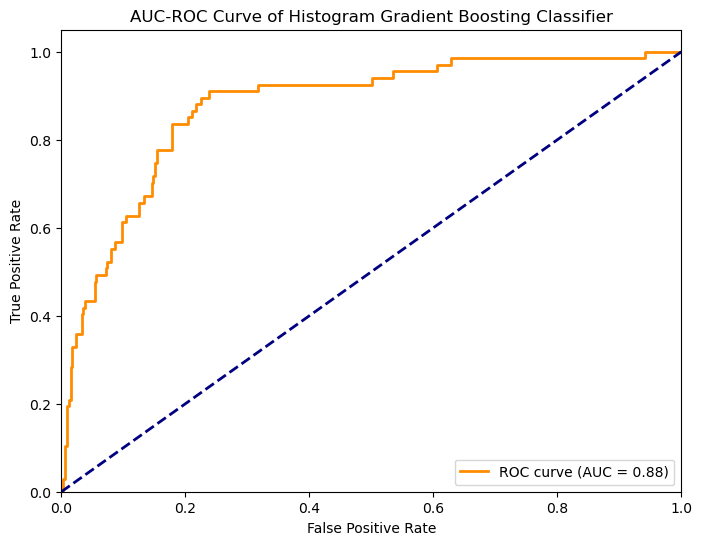

In [39]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
from sklearn.ensemble import HistGradientBoostingClassifier
import matplotlib.pyplot as plt

# Load the merged data
merged_data = pd.read_csv('/Users/sanohijatav/Downloads/Business_Project/F1_Dataset/merged_race_data.csv') # Adjust the path accordingly

# Load the 2024 race calendar
calendar_2024 = pd.read_csv('/Users/sanohijatav/Downloads/Business_Project/F1_Dataset/2024/formula1_2024season_calendar.csv') # Adjust the path accordingly

# Feature engineering
def create_podium_feature(position):
    return 1 if position <= 3 else 0

merged_data['Podium'] = merged_data['Position'].apply(create_podium_feature)

def create_track_history(df):
    df['TrackPerformance'] = df.groupby(['Driver', 'Country'])['Position'].transform(lambda x: x.shift().rolling(window=3, min_periods=1).mean())
    return df

def add_recent_form(df):
    df['RecentForm'] = df.groupby('Driver')['Position'].transform(lambda x: x.shift().rolling(window=5, min_periods=1).mean())
    return df

merged_data = create_track_history(merged_data)
merged_data = add_recent_form(merged_data)

# Prepare features and target
features = ['TrackPerformance', 'RecentForm', 'Driver', 'Team', 'Country']
X = merged_data[features]
y = merged_data['Podium']

# Split the data for ROC curve
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create preprocessor
numeric_features = ['TrackPerformance', 'RecentForm']
categorical_features = ['Driver', 'Team', 'Country']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_features)
    ])

# Create the model pipeline
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', HistGradientBoostingClassifier(random_state=42))
])

# Perform cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
print(f"Histogram Gradient Boosting Classifier Model")
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Train the model on the training set
model.fit(X_train, y_train)

# Calculate accuracy on test set
y_pred = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test set accuracy: {test_accuracy:.4f}")

# Generate classification report
report = classification_report(y_test, y_pred)
print("\nClassification Report:")
print(report)

# Compute ROC curve and ROC area
y_pred_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot AUC-ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curve of Histogram Gradient Boosting Classifier')
plt.legend(loc="lower right")
plt.show()

# Train the model on the full dataset for predictions
model.fit(X, y)

# Load the 2024 drivers data
drivers_2024 = pd.read_csv('/Users/sanohijatav/Downloads/Business_Project/F1_Dataset/2024/formula1_2024season_drivers.csv') # Adjust the path accordingly

# Function to get the most recent team for each driver
def get_most_recent_teams(historical_data):
    most_recent = historical_data.sort_values('Year', ascending=False).drop_duplicates(subset='Driver')
    return dict(zip(most_recent['Driver'], most_recent['Team']))

# Get the most recent teams
recent_teams = get_most_recent_teams(merged_data)

def predict_top_3(race_info, drivers_df, model, historical_data, recent_teams):
    race_data = []
    for _, driver_row in drivers_df.iterrows():
        driver = driver_row['Driver']
        team = recent_teams.get(driver, 'Unknown')
        driver_history = historical_data[historical_data['Driver'] == driver]
        
        if driver_history.empty:
            track_performance = historical_data['Position'].mean()
            recent_form = historical_data['Position'].mean()
        else:
            track_performance = driver_history[driver_history['Country'] == race_info['Country']]['Position'].mean()
            recent_form = driver_history.sort_values('Year', ascending=False)['Position'].head(5).mean()
        
        race_data.append({
            'TrackPerformance': track_performance if not np.isnan(track_performance) else historical_data['Position'].mean(),
            'RecentForm': recent_form if not np.isnan(recent_form) else historical_data['Position'].mean(),
            'Driver': driver,
            'Team': team,
            'Country': race_info['Country']
        })
    
    race_df = pd.DataFrame(race_data)
    probabilities = model.predict_proba(race_df)[:, 1]
    race_df['PodiumProbability'] = probabilities
    return race_df.nlargest(3, 'PodiumProbability')

# Predict for 2024 season
predictions_2024 = []

for _, race in calendar_2024.iterrows():
    top_3 = predict_top_3(race, drivers_2024, model, merged_data, recent_teams)
    predictions_2024.append({
        'Race': race['GP Name'],
        'Predictions': top_3[['Driver', 'Team', 'PodiumProbability']]
    })


### Formatting and Displaying the results in a tabular format

In [40]:
import pandas as pd
from tabulate import tabulate
from datetime import datetime

# Load the 2024 race results (up to Belgian GP)
race_results_2024 = pd.read_csv('/Users/sanohijatav/Downloads/Business_Project/F1_Dataset/2024/formula1_2024season_raceresults.csv') # Adjust the path accordingly

# Load the 2024 race calendar
calendar_2024 = pd.read_csv('/Users/sanohijatav/Downloads/Business_Project/F1_Dataset/2024/formula1_2024season_calendar.csv') # Adjust the path accordingly

def map_race_to_country(race_name):
    mapping = {
        'Gulf Air Bahrain GP': 'Bahrain',
        'STC Saudi Arabian GP': 'Saudi Arabia',
        'Rolex Australian GP': 'Australia',
        'MSC Cruises Japanese GP': 'Japan',
        'Lenovo Chinese GP': 'China',
        'Crypto.com Miami GP': 'Miami',
        'Qatar Airways Gran Premio Del Made In Italy e Dell Emilia-Romagna': 'Emilia Romagna',
        'Grand Prix de Monaco': 'Monaco',
        'AWS Grand Prix du Canada': 'Canada',
        'Aramco Gran Premio de Espana': 'Spain',
        'Qatar Airways Austrian GP': 'Austria',
        'Qatar Airways British GP': 'Great Britain',
        'Hungarian GP': 'Hungary',
        'Rolex Belgian GP': 'Belgium',
        'Heineken Dutch GP': 'Netherlands',
        'Pirelli Gran Premio D Italia': 'Italy',
        'Qatar Airways Azerbaijan GP': 'Azerbaijan',
        'Singapore Airlines Singapore GP': 'Singapore',
        'Pirelli United States GP': 'United States',
        'Gran Premio de la Ciudad de Mexico': 'Mexico',
        'Lenovo Grande Premio de Sao Paulo': 'Brazil',
        'Heineken Silver Las Vegas GP': 'United States',
        'Qatar Airways Qatar GP': 'Qatar',
        'Etihad Airways Abu Dhabi GP': 'Abu Dhabi'
    }
    return mapping.get(race_name, race_name)

# Ensure 'Position' column is numeric
race_results_2024['Position'] = pd.to_numeric(race_results_2024['Position'], errors='coerce')

# Create a dictionary to map race names to countries
race_to_country = {race['Race']: map_race_to_country(race['Race']) for race in predictions_2024}

# Create a dictionary to map race names to dates
race_to_date = dict(zip(calendar_2024['GP Name'], calendar_2024['Race Date']))

# Get team mapping
team_mapping = get_team_mapping()

# Create an empty list to store our formatted results
formatted_results_list = []

for prediction in predictions_2024:
    race_name = prediction['Race']
    country = race_to_country[race_name]
    race_date = race_to_date.get(race_name, 'Date unknown')
    
    # Include PodiumProbability in the predicted top 3
    predicted_top_3 = prediction['Predictions'][['Driver', 'Team', 'PodiumProbability']].head(3).values.tolist()
    
    # Normalize team names in predictions
    for i in range(len(predicted_top_3)):
        predicted_top_3[i][1] = normalize_team_name(predicted_top_3[i][1], team_mapping)
    
    # Find the corresponding results for this race
    actual_result = race_results_2024[race_results_2024['Country'] == country]
    
    if not actual_result.empty:
        actual_top_3 = actual_result[actual_result['Position'].isin([1, 2, 3])].sort_values('Position')[['Driver', 'Team']].values.tolist()
        
        # Normalize team names in actual results
        for i in range(len(actual_top_3)):
            actual_top_3[i][1] = normalize_team_name(actual_top_3[i][1], team_mapping)
        
        actual_top_3 = actual_top_3 + [['', '']] * (3 - len(actual_top_3))
    else:
        actual_top_3 = [['TBD', 'TBD']] * 3  # Use TBD if no results are available
    
    for i in range(3):
        formatted_results_list.append([
            race_name if i == 0 else '',
            race_date if i == 0 else '',
            i + 1,
            f"{predicted_top_3[i][0]} ({predicted_top_3[i][2]:.2f})",
            predicted_top_3[i][1],
            actual_top_3[i][0],
            actual_top_3[i][1]
        ])
    
    # Add an empty row for spacing between races
    formatted_results_list.append([''] * 7)

# Create headers for the table
headers = ['GP Name', 'Race Date', 'Position', 'Predicted Driver (Probability)', 'Predicted Team', 'Actual Driver', 'Actual Team']

table = tabulate(formatted_results_list, headers=headers, tablefmt="grid")

# Print the table
print("Gradient Booster Classifier Results:")
print(table)

# Optionally, save the table to a file
with open('f1_2024_results_comparison.txt', 'w') as f:
    f.write("Gradient Booster Classifier Results:\n")
    f.write(table)

Gradient Booster Classifier Results:
+-------------------------------------------------------------------+-------------+------------+----------------------------------+------------------+-----------------+---------------+
| GP Name                                                           | Race Date   | Position   | Predicted Driver (Probability)   | Predicted Team   | Actual Driver   | Actual Team   |
+===================================================================+=============+============+==================================+==================+=================+===============+
| Gulf Air Bahrain GP                                               | 02/03/2024  | 1          | Max Verstappen (0.80)            | Red Bull         | Max Verstappen  | Red Bull      |
+-------------------------------------------------------------------+-------------+------------+----------------------------------+------------------+-----------------+---------------+
|                                     

### PREDICTION MODEL: Random Forest Classifier

Random Forest Classifier Model
Cross-validation scores: [0.85891089 0.86848635 0.86848635 0.85359801 0.86104218]
Mean CV score: 0.8621 (+/- 0.0115)

Accuracy on test set: 0.8663

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.95      0.92       337
           1       0.64      0.45      0.53        67

    accuracy                           0.87       404
   macro avg       0.77      0.70      0.72       404
weighted avg       0.85      0.87      0.86       404



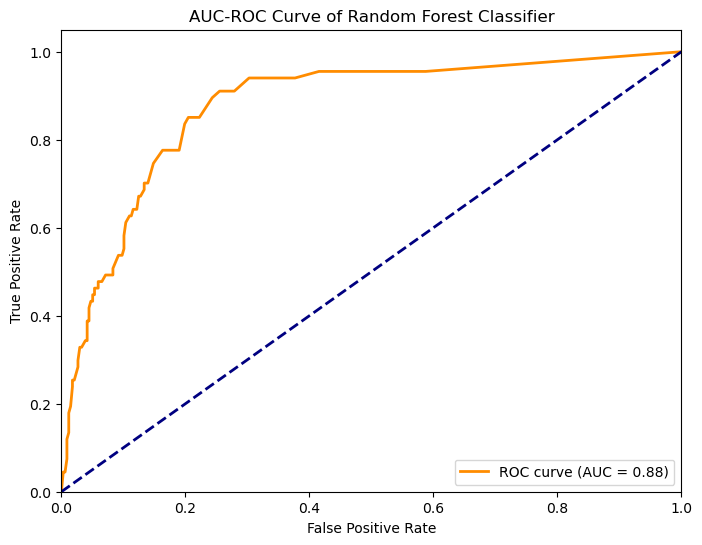

In [41]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# Load the merged data
merged_data = pd.read_csv('/Users/sanohijatav/Downloads/Business_Project/F1_Dataset/merged_race_data.csv') # Adjust the path accordingly

# Load the 2024 race calendar
calendar_2024 = pd.read_csv('/Users/sanohijatav/Downloads/Business_Project/F1_Dataset/2024/formula1_2024season_calendar.csv') # Adjust the path accordingly

# Feature engineering
def create_podium_feature(position):
    return 1 if position <= 3 else 0

merged_data['Podium'] = merged_data['Position'].apply(create_podium_feature)

def create_track_history(df):
    df['TrackPerformance'] = df.groupby(['Driver', 'Country'])['Position'].transform(lambda x: x.shift().rolling(window=3, min_periods=1).mean())
    return df

def add_recent_form(df):
    df['RecentForm'] = df.groupby('Driver')['Position'].transform(lambda x: x.shift().rolling(window=5, min_periods=1).mean())
    return df

merged_data = create_track_history(merged_data)
merged_data = add_recent_form(merged_data)

# Prepare features and target
features = ['TrackPerformance', 'RecentForm', 'Driver', 'Team', 'Country']
X = merged_data[features]
y = merged_data['Podium']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create preprocessor
numeric_features = ['TrackPerformance', 'RecentForm']
categorical_features = ['Driver', 'Team', 'Country']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_features)
    ])

# Create the Random Forest model
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Create the pipeline
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', rf_classifier)
])

# Perform cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')

print(f"Random Forest Classifier Model")
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Fit the model on the entire training set
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
print(f"\nAccuracy on test set: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Calculate ROC curve and AUC
y_pred_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot AUC-ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curve of Random Forest Classifier')
plt.legend(loc="lower right")
plt.show()

# Load the 2024 drivers data
drivers_2024 = pd.read_csv('/Users/sanohijatav/Downloads/Business_Project/F1_Dataset/2024/formula1_2024season_drivers.csv') # Adjust the path accordingly

# Function to get the most recent team for each driver
def get_most_recent_teams(historical_data):
    most_recent = historical_data.sort_values('Year', ascending=False).drop_duplicates(subset='Driver')
    return dict(zip(most_recent['Driver'], most_recent['Team']))

# Get the most recent teams
recent_teams = get_most_recent_teams(merged_data)

def predict_top_3(race_info, drivers_df, model, historical_data, recent_teams):
    race_data = []
    for _, driver_row in drivers_df.iterrows():
        driver = driver_row['Driver']
        team = recent_teams.get(driver, 'Unknown')
        driver_history = historical_data[historical_data['Driver'] == driver]
        
        if driver_history.empty:
            track_performance = historical_data['Position'].mean()
            recent_form = historical_data['Position'].mean()
        else:
            track_performance = driver_history[driver_history['Country'] == race_info['Country']]['Position'].mean()
            recent_form = driver_history.sort_values('Year', ascending=False)['Position'].head(5).mean()
        
        race_data.append({
            'TrackPerformance': track_performance if not np.isnan(track_performance) else historical_data['Position'].mean(),
            'RecentForm': recent_form if not np.isnan(recent_form) else historical_data['Position'].mean(),
            'Driver': driver,
            'Team': team,
            'Country': race_info['Country']
        })
    
    race_df = pd.DataFrame(race_data)
    probabilities = model.predict_proba(race_df)[:, 1]
    race_df['rf_probability'] = probabilities
    return race_df.nlargest(3, 'rf_probability')

# Predict for 2024 season
rf_predictions_2024 = []

for _, race in calendar_2024.iterrows():
    top_3 = predict_top_3(race, drivers_2024, model, merged_data, recent_teams)
    rf_predictions_2024.append({
        'Race': race['GP Name'],
        'Predictions': top_3[['Driver', 'Team', 'rf_probability']]
    })


### Formatting and Displaying the results in a tabular format

In [42]:
import pandas as pd
from tabulate import tabulate
from datetime import datetime

# Load the 2024 race results (up to Belgian GP)
race_results_2024 = pd.read_csv('/Users/sanohijatav/Downloads/Business_Project/F1_Dataset/2024/formula1_2024season_raceresults.csv')

# Load the 2024 race calendar
calendar_2024 = pd.read_csv('/Users/sanohijatav/Downloads/Business_Project/F1_Dataset/2024/formula1_2024season_calendar.csv')

def map_race_to_country(race_name):
    mapping = {
        'Gulf Air Bahrain GP': 'Bahrain',
        'STC Saudi Arabian GP': 'Saudi Arabia',
        'Rolex Australian GP': 'Australia',
        'MSC Cruises Japanese GP': 'Japan',
        'Lenovo Chinese GP': 'China',
        'Crypto.com Miami GP': 'Miami',
        'Qatar Airways Gran Premio Del Made In Italy e Dell Emilia-Romagna': 'Emilia Romagna',
        'Grand Prix de Monaco': 'Monaco',
        'AWS Grand Prix du Canada': 'Canada',
        'Aramco Gran Premio de Espana': 'Spain',
        'Qatar Airways Austrian GP': 'Austria',
        'Qatar Airways British GP': 'Great Britain',
        'Hungarian GP': 'Hungary',
        'Rolex Belgian GP': 'Belgium',
        'Heineken Dutch GP': 'Netherlands',
        'Pirelli Gran Premio D Italia': 'Italy',
        'Qatar Airways Azerbaijan GP': 'Azerbaijan',
        'Singapore Airlines Singapore GP': 'Singapore',
        'Pirelli United States GP': 'United States',
        'Gran Premio de la Ciudad de Mexico': 'Mexico',
        'Lenovo Grande Premio de Sao Paulo': 'Brazil',
        'Heineken Silver Las Vegas GP': 'United States',
        'Qatar Airways Qatar GP': 'Qatar',
        'Etihad Airways Abu Dhabi GP': 'Abu Dhabi'
    }
    return mapping.get(race_name, race_name)

# Ensure 'Position' column is numeric
race_results_2024['Position'] = pd.to_numeric(race_results_2024['Position'], errors='coerce')

# Create a dictionary to map race names to countries
race_to_country = {race['Race']: map_race_to_country(race['Race']) for race in rf_predictions_2024}

# Create a dictionary to map race names to dates
race_to_date = dict(zip(calendar_2024['GP Name'], calendar_2024['Race Date']))

# Create an empty list to store our formatted results
formatted_results_list = []

current_date = datetime.now().date()

for prediction in rf_predictions_2024:
    race_name = prediction['Race']
    country = race_to_country[race_name]
    race_date = race_to_date.get(race_name, 'Date unknown')
    
    # Check if the race date has passed
    race_date_obj = datetime.strptime(race_date, '%d/%m/%Y').date()
    
    # Include rf_probability in the predicted top 3
    predicted_top_3 = prediction['Predictions'][['Driver', 'Team', 'rf_probability']].head(3).values.tolist()
    
    # Find the corresponding results for this race
    actual_result = race_results_2024[race_results_2024['Country'] == country]
    
    if not actual_result.empty:
        actual_top_3 = actual_result[actual_result['Position'].isin([1, 2, 3])].sort_values('Position')[['Driver', 'Team']].values.tolist()
        actual_top_3 = actual_top_3 + [['', '']] * (3 - len(actual_top_3))
    else:
        actual_top_3 = [['TBD', 'TBD']] * 3  # Use TBD if no results are available, regardless of date
    
    for i in range(3):
        formatted_results_list.append([
            race_name if i == 0 else '',
            race_date if i == 0 else '',
            i + 1,
            f"{predicted_top_3[i][0]} ({predicted_top_3[i][2]:.2f})",
            predicted_top_3[i][1],
            actual_top_3[i][0],
            actual_top_3[i][1]
        ])
    
    # Add an empty row for spacing between races
    formatted_results_list.append([''] * 7)

# Create headers for the table
headers = ['GP Name', 'Race Date', 'Position', 'Predicted Driver (Probability)', 'Predicted Team', 'Actual Driver', 'Actual Team']

# Use tabulate to create a nicely formatted table
table = tabulate(formatted_results_list, headers=headers, tablefmt="grid")

# Print the table
print("Random Forest Classifier Results:")
print(table)

# Optionally, save the table to a file
with open('f1_2024_rf_results_comparison.txt', 'w') as f:
    f.write("Random Forest Classifier Results:\n")
    f.write(table)

Random Forest Classifier Results:
+-------------------------------------------------------------------+-------------+------------+----------------------------------+----------------------------+-----------------+----------------------------+
| GP Name                                                           | Race Date   | Position   | Predicted Driver (Probability)   | Predicted Team             | Actual Driver   | Actual Team                |
+===================================================================+=============+============+==================================+============================+=================+============================+
| Gulf Air Bahrain GP                                               | 02/03/2024  | 1          | Max Verstappen (0.70)            | Red Bull Racing Honda RBPT | Max Verstappen  | Red Bull Racing Honda RBPT |
+-------------------------------------------------------------------+-------------+------------+----------------------------------+---

## XG BOOST CLASSIFIER MODEL

/Users/sanohijatav/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:39:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/sanohijatav/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:39:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/sanohijatav/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:39:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/sanohijatav/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:39:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(sms

XGBoost Classifier Model
Cross-validation scores: [0.8539604  0.85856079 0.86352357 0.84367246 0.8337469 ]
Mean CV accuracy: 0.8507 (+/- 0.0214)
Test set accuracy: 0.8614

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92       337
           1       0.61      0.46      0.53        67

    accuracy                           0.86       404
   macro avg       0.75      0.70      0.72       404
weighted avg       0.85      0.86      0.85       404



/Users/sanohijatav/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:39:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


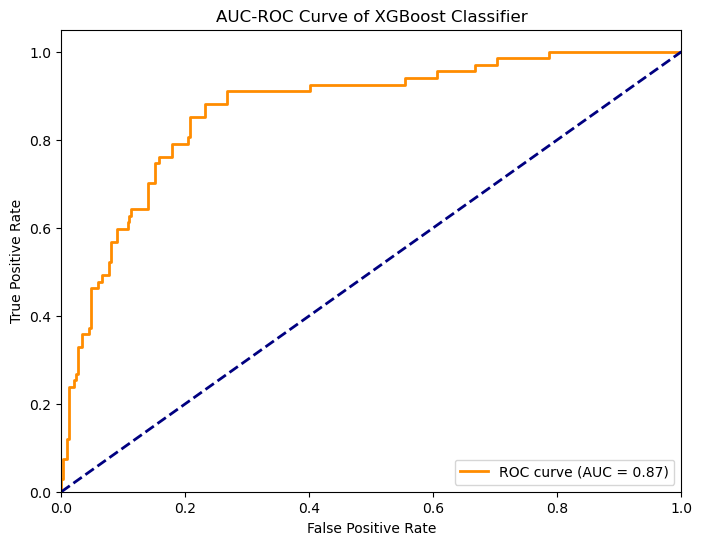

/Users/sanohijatav/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:39:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [43]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

# Load the merged data
merged_data = pd.read_csv('/Users/sanohijatav/Downloads/Business_Project/F1_Dataset/merged_race_data.csv') # Adjust the path accordingly

# Load the 2024 race calendar
calendar_2024 = pd.read_csv('/Users/sanohijatav/Downloads/Business_Project/F1_Dataset/2024/formula1_2024season_calendar.csv') # Adjust the path accordingly

# Feature engineering
def create_podium_feature(position):
    return 1 if position <= 3 else 0

merged_data['Podium'] = merged_data['Position'].apply(create_podium_feature)

def create_track_history(df):
    df['TrackPerformance'] = df.groupby(['Driver', 'Country'])['Position'].transform(lambda x: x.shift().rolling(window=3, min_periods=1).mean())
    return df

def add_recent_form(df):
    df['RecentForm'] = df.groupby('Driver')['Position'].transform(lambda x: x.shift().rolling(window=5, min_periods=1).mean())
    return df

merged_data = create_track_history(merged_data)
merged_data = add_recent_form(merged_data)

# Prepare features and target
features = ['TrackPerformance', 'RecentForm', 'Driver', 'Team', 'Country']
X = merged_data[features]
y = merged_data['Podium']

# Split the data for ROC curve
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create preprocessor
numeric_features = ['TrackPerformance', 'RecentForm']
categorical_features = ['Driver', 'Team', 'Country']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_features)
    ])

# Create the model pipeline with XGBoost
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))
])

# Perform cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')

print(f"XGBoost Classifier Model")
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Train the model on the training set
model.fit(X_train, y_train)

# Calculate accuracy on test set
y_pred = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test set accuracy: {test_accuracy:.4f}")

# Generate classification report
report = classification_report(y_test, y_pred)
print("\nClassification Report:")
print(report)

# Compute ROC curve and ROC area
y_pred_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot AUC-ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curve of XGBoost Classifier')
plt.legend(loc="lower right")
plt.show()

# Train the model on the full dataset for predictions
model.fit(X, y)

# Load the 2024 drivers data
drivers_2024 = pd.read_csv('/Users/sanohijatav/Downloads/Business_Project/F1_Dataset/2024/formula1_2024season_drivers.csv') # Adjust the path accordingly

# Function to get the most recent team for each driver
def get_most_recent_teams(historical_data):
    most_recent = historical_data.sort_values('Year', ascending=False).drop_duplicates(subset='Driver')
    return dict(zip(most_recent['Driver'], most_recent['Team']))

# Get the most recent teams
recent_teams = get_most_recent_teams(merged_data)

def predict_top_3(race_info, drivers_df, model, historical_data, recent_teams):
    race_data = []
    for _, driver_row in drivers_df.iterrows():
        driver = driver_row['Driver']
        team = recent_teams.get(driver, 'Unknown')
        driver_history = historical_data[historical_data['Driver'] == driver]
        
        if driver_history.empty:
            track_performance = historical_data['Position'].mean()
            recent_form = historical_data['Position'].mean()
        else:
            track_performance = driver_history[driver_history['Country'] == race_info['Country']]['Position'].mean()
            recent_form = driver_history.sort_values('Year', ascending=False)['Position'].head(5).mean()
        
        race_data.append({
            'TrackPerformance': track_performance if not np.isnan(track_performance) else historical_data['Position'].mean(),
            'RecentForm': recent_form if not np.isnan(recent_form) else historical_data['Position'].mean(),
            'Driver': driver,
            'Team': team,
            'Country': race_info['Country']
        })
    
    race_df = pd.DataFrame(race_data)
    probabilities = model.predict_proba(race_df)[:, 1]
    race_df['PodiumProbability'] = probabilities
    return race_df.nlargest(3, 'PodiumProbability')

# Predict for 2024 season
predictions_2024 = []

for _, race in calendar_2024.iterrows():
    top_3 = predict_top_3(race, drivers_2024, model, merged_data, recent_teams)
    predictions_2024.append({
        'Race': race['GP Name'],
        'Predictions': top_3[['Driver', 'Team', 'PodiumProbability']]
    })


### Formatting and Displaying the results in a tabular format

In [44]:
import pandas as pd
from tabulate import tabulate
from datetime import datetime

# Load the 2024 race results (up to Belgian GP)
race_results_2024 = pd.read_csv('/Users/sanohijatav/Downloads/Business_Project/F1_Dataset/2024/formula1_2024season_raceresults.csv') # Adjust the path accordingly

# Load the 2024 race calendar
calendar_2024 = pd.read_csv('/Users/sanohijatav/Downloads/Business_Project/F1_Dataset/2024/formula1_2024season_calendar.csv') # Adjust the path accordingly

def map_race_to_country(race_name):
    mapping = {
        'Gulf Air Bahrain GP': 'Bahrain',
        'STC Saudi Arabian GP': 'Saudi Arabia',
        'Rolex Australian GP': 'Australia',
        'MSC Cruises Japanese GP': 'Japan',
        'Lenovo Chinese GP': 'China',
        'Crypto.com Miami GP': 'Miami',
        'Qatar Airways Gran Premio Del Made In Italy e Dell Emilia-Romagna': 'Emilia Romagna',
        'Grand Prix de Monaco': 'Monaco',
        'AWS Grand Prix du Canada': 'Canada',
        'Aramco Gran Premio de Espana': 'Spain',
        'Qatar Airways Austrian GP': 'Austria',
        'Qatar Airways British GP': 'Great Britain',
        'Hungarian GP': 'Hungary',
        'Rolex Belgian GP': 'Belgium',
        'Heineken Dutch GP': 'Netherlands',
        'Pirelli Gran Premio D Italia': 'Italy',
        'Qatar Airways Azerbaijan GP': 'Azerbaijan',
        'Singapore Airlines Singapore GP': 'Singapore',
        'Pirelli United States GP': 'United States',
        'Gran Premio de la Ciudad de Mexico': 'Mexico',
        'Lenovo Grande Premio de Sao Paulo': 'Brazil',
        'Heineken Silver Las Vegas GP': 'United States',
        'Qatar Airways Qatar GP': 'Qatar',
        'Etihad Airways Abu Dhabi GP': 'Abu Dhabi'
    }
    return mapping.get(race_name, race_name)

# Ensure 'Position' column is numeric
race_results_2024['Position'] = pd.to_numeric(race_results_2024['Position'], errors='coerce')

# Create a dictionary to map race names to countries
race_to_country = {race['Race']: map_race_to_country(race['Race']) for race in predictions_2024}

# Create a dictionary to map race names to dates
race_to_date = dict(zip(calendar_2024['GP Name'], calendar_2024['Race Date']))

# Get team mapping
team_mapping = get_team_mapping()

# Create an empty list to store our formatted results
formatted_results_list = []

current_date = datetime.now().date()

for prediction in predictions_2024:
    race_name = prediction['Race']
    country = race_to_country[race_name]
    race_date = race_to_date.get(race_name, 'Date unknown')
    
    # Check if the race date has passed
    race_date_obj = datetime.strptime(race_date, '%d/%m/%Y').date()
    
    # Include PodiumProbability in the predicted top 3
    predicted_top_3 = prediction['Predictions'][['Driver', 'Team', 'PodiumProbability']].head(3).values.tolist()
    
    # Normalize team names in predictions
    for i in range(len(predicted_top_3)):
        predicted_top_3[i][1] = normalize_team_name(predicted_top_3[i][1], team_mapping)
    
    # Find the corresponding results for this race
    actual_result = race_results_2024[race_results_2024['Country'] == country]
    
    if not actual_result.empty:
        # Convert 'Position' to numeric, setting non-numeric values to NaN
        actual_result = actual_result.assign(Position=pd.to_numeric(actual_result['Position'], errors='coerce'))
        
        # Filter out rows where Position is NaN 
        actual_result = actual_result.dropna(subset=['Position'])
        
        # Convert to int
        actual_result['Position'] = actual_result['Position'].astype(int)
        
        actual_top_3 = actual_result[actual_result['Position'].isin([1, 2, 3])].sort_values('Position')[['Driver', 'Team']].values.tolist()
        
        # Normalize team names in actual results
        for i in range(len(actual_top_3)):
            actual_top_3[i][1] = normalize_team_name(actual_top_3[i][1], team_mapping)
        
        actual_top_3 = actual_top_3 + [['', '']] * (3 - len(actual_top_3))
    else:
        actual_top_3 = [['TBD', 'TBD']] * 3
    
    for i in range(3):
        formatted_results_list.append([
            race_name if i == 0 else '',
            race_date if i == 0 else '',
            i + 1,
            f"{predicted_top_3[i][0]} ({predicted_top_3[i][2]:.2f})",
            predicted_top_3[i][1],
            actual_top_3[i][0],
            actual_top_3[i][1]
        ])
    
    # Add an empty row for spacing between races
    formatted_results_list.append([''] * 7)

# Create headers for the table
headers = ['GP Name', 'Race Date', 'Position', 'XGB Predicted Driver (Probability)', 'XGB Predicted Team', 'Actual Driver', 'Actual Team']

# Use tabulate to create a nicely formatted table
table = tabulate(formatted_results_list, headers=headers, tablefmt="grid")

# Print the table
print("XGBoost Classifier Results:")
print(table)

# Optionally, save the table to a file
with open('f1_2024_xgb_results_comparison.txt', 'w') as f:
    f.write("XGBoost Classifier Results:\n")
    f.write(table)

XGBoost Classifier Results:
+-------------------------------------------------------------------+-------------+------------+--------------------------------------+----------------------+-----------------+---------------+
| GP Name                                                           | Race Date   | Position   | XGB Predicted Driver (Probability)   | XGB Predicted Team   | Actual Driver   | Actual Team   |
+===================================================================+=============+============+======================================+======================+=================+===============+
| Gulf Air Bahrain GP                                               | 02/03/2024  | 1          | Max Verstappen (0.71)                | Red Bull             | Max Verstappen  | Red Bull      |
+-------------------------------------------------------------------+-------------+------------+--------------------------------------+----------------------+-----------------+---------------+
|      